<a href="https://colab.research.google.com/github/MinakoNG63/DSFB/blob/main/26_Other_Linear_Discriminant_Models_63070240.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 26 - Other Linear Discriminant Models and Estimating Probabilities

Term 1 2022 - Instructor: Teerapong Leelanupab

Teaching Assistant:
1. Piyawat Chuangkrud (Sam)
2. Suvapat Manu (Mint)

***

In [ ]:
#---------------------------------
#download files จาก google drive
#---------------------------------
#download winequality.csv only for this notebook
!mkdir data
!gdown --id 1-EdBE81ktQpS01ZNN_VJ802qGPHbQhmD -O data/winequality.csv

#download ds_utils.zip only for this notebook
!gdown --id 1-Vyxd6XkSHTyXuU2f_VUZMao06aW2iyI -O ds_utils.zip
!unzip ds_utils.zip

mkdir: cannot create directory ‘data’: File exists
Downloading...
From: https://drive.google.com/uc?id=1-EdBE81ktQpS01ZNN_VJ802qGPHbQhmD
To: /content/data/winequality.csv
100% 101k/101k [00:00<00:00, 891kB/s]
usage: gdown [-h] [-V] [-O OUTPUT] [-q] [--id] url_or_id
gdown: error: unrecognized arguments: -f
Archive:  ds_utils.zip
replace __MACOSX/._ds_utils? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/._ds_utils     
  inflating: ds_utils/.DS_Store      
  inflating: __MACOSX/ds_utils/._.DS_Store  
  inflating: ds_utils/__init__.py    
  inflating: __MACOSX/ds_utils/.___init__.py  
  inflating: ds_utils/decision_surface.py  
  inflating: __MACOSX/ds_utils/._decision_surface.py  
  inflating: __MACOSX/ds_utils/._data  
  inflating: ds_utils/data/spam_ham.csv  
  inflating: __MACOSX/ds_utils/data/._spam_ham.csv  


## Packages

In [ ]:
# Import the libraries we will be using

import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks', palette='Set2')

# some custom libraries!
import sys
sys.path.append("..")
from ds_utils.decision_surface import *

Notice that we're importing library code that we've developed just for this class. In the future, new common code will continue to be added to the `ds_utils` folder. Have some code you use frequently? Consider adding it to that folder as your own library!

## Motivational example

Imagine we have some noisy observations from a nonlinear function. We're going to approximate that function by fitting a polynomial to the observations.

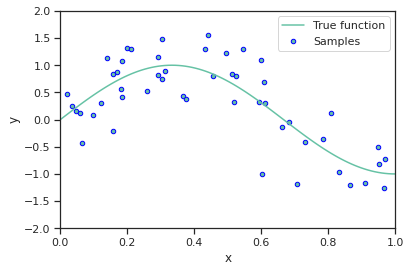

In [ ]:
num_samples = 50
# Set randomness so that we all get the same answer
np.random.seed(42)

def true_function(X):
    return np.sin(1.5 * np.pi * X)

def plot_example(X, Y, functions):
    # Get some X's to plot the functions
    X_test = pd.DataFrame(np.linspace(0, 1, 100), columns=['X'])
    # Plot stuff
    for key in functions:
        plt.plot(X_test, functions[key](X_test), label=key)
    plt.scatter(X, Y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")

# Add X in the range of [0, 1]
X = pd.DataFrame(np.sort(np.random.rand(num_samples)), columns=['x1'])
# Add some random noise to the observations
Y = true_function(X.x1) + np.random.randn(num_samples) * 0.5
# Plot stuff
functions = {"True function": true_function}
plot_example(X, Y, functions)
plt.show()

Let's assume that we don't know the true function, choosing to model our noisy observations using linear regression.  (Recall that we built linear regression models in Class #1; compare with the fitting of models for binary target variables from last class.)

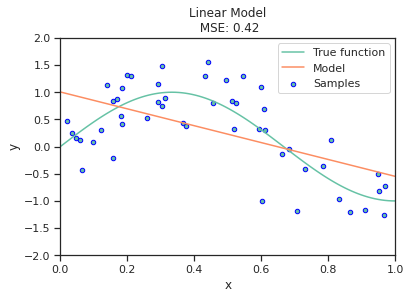

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Fit linear model
model = LinearRegression()
model.fit(X, Y)
# Evaluate model with mean squared error; just as an example
mse = mean_squared_error(Y, model.predict(X))
# Plot results
functions["Model"] = model.predict
plot_example(X, Y, functions)
#Note how you can customize your plots
plt.title("Linear Model\n MSE: %.2f" % mse)
plt.show()

Clearly the linear regression doesn't fit our data super well. Rather than trying a linear regression, let's attempt polynomial regression. How do different degree polynomials fit the data? Recall that a polynomial on a single variable looks like:

$$ a_1 + a_2 x + a_3 x^2 + ... $$

In [ ]:
##
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def fit_polynomial(X, Y, degree):
    # create different powers of X
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression)])
    pipeline.fit(X, Y)
    return pipeline

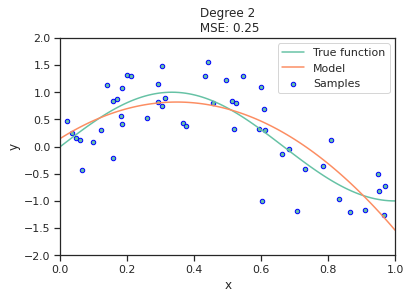

In [ ]:
def plot_poly(X, Y, degree):
    # Fit polynomial model
    model = fit_polynomial(X, Y, degree)
    # Evaluate model
    mse = mean_squared_error(Y, model.predict(X))
    # Plot results
    functions["Model"] = model.predict
    plt.title("Degree %d\n MSE: %.2f" % (degree, mse))
    plot_example(X, Y, functions)

plot_poly(X, Y, degree=2)
plt.show()

This seems to fit our data better than the purely linear model. What if we use polynomials with higher degrees?

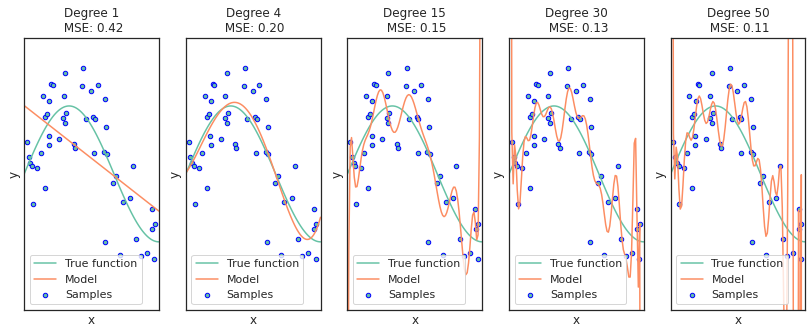

In [ ]:
plt.figure(figsize=(14, 5))
# degrees of the polynomial
degrees = [1, 4, 15, 30, 50]
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())
    plot_poly(X, Y, degrees[i])
plt.show()

What do you see there as the effect of allowing more complexity in the modeling process? Take a loot at what happens when we use a regression tree on data generated from the true function.

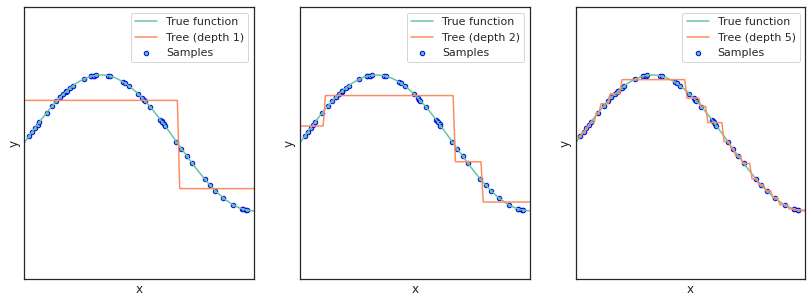

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

Expected_Y = true_function(X.x1)
plt.figure(figsize=(14, 5))
# Fit Regression Trees
depths = [1, 2, 5]
for i, depth in enumerate(depths):
    ax = plt.subplot(1, len(depths), i + 1)
    plt.setp(ax, xticks=(), yticks=())
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(X, Expected_Y)
    functions = {"True function": true_function, "Tree (depth {})".format(depth): model.predict}
    plot_example(X, Expected_Y, functions)
plt.show()

## Predicting wine quality

_"All wines should be tasted; some should only be sipped, but with others, drink the whole bottle."_ - Paulo Coelho, Brida

We will use a data set related to the red variant of the Portuguese "Vinho Verde" wine. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.). Our goal is to use machine learning to detect above-average wines (perhaps to send these wines later to professional tasters?).

Let's start by loading the data.

In [ ]:
path = "data/winequality.csv"
wine_df = pd.read_csv(path).dropna()
# We will change the label to reflect our decision problem, namely, to identify above-average wines.
avg_quality = wine_df.quality.mean()
wine_df["is_good"] = wine_df.quality > avg_quality
#Note above the "Pandas" way of doing things: process all the instances simultaneously
#   computing the mean in one swoop; assigning the new column all at once.

#Now we will get rid of the old feature quality.
#  Ask yourself: what would have happened if had used it in predicting the new target?
#    (Hint: leakage)
wine_df = wine_df.drop("quality", axis="columns")
# Replace white spaces for underscores in column names
wine_df.columns = [c.replace(' ', '_') for c in wine_df.columns]
# Get column names and predictor columns
column_names = wine_df.columns
predictor_columns = column_names[:-1]
wine_df.head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,is_good
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,False
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,False
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,False
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,True
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,False


Let's see if any of the features seem to be very predictive by themselves.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

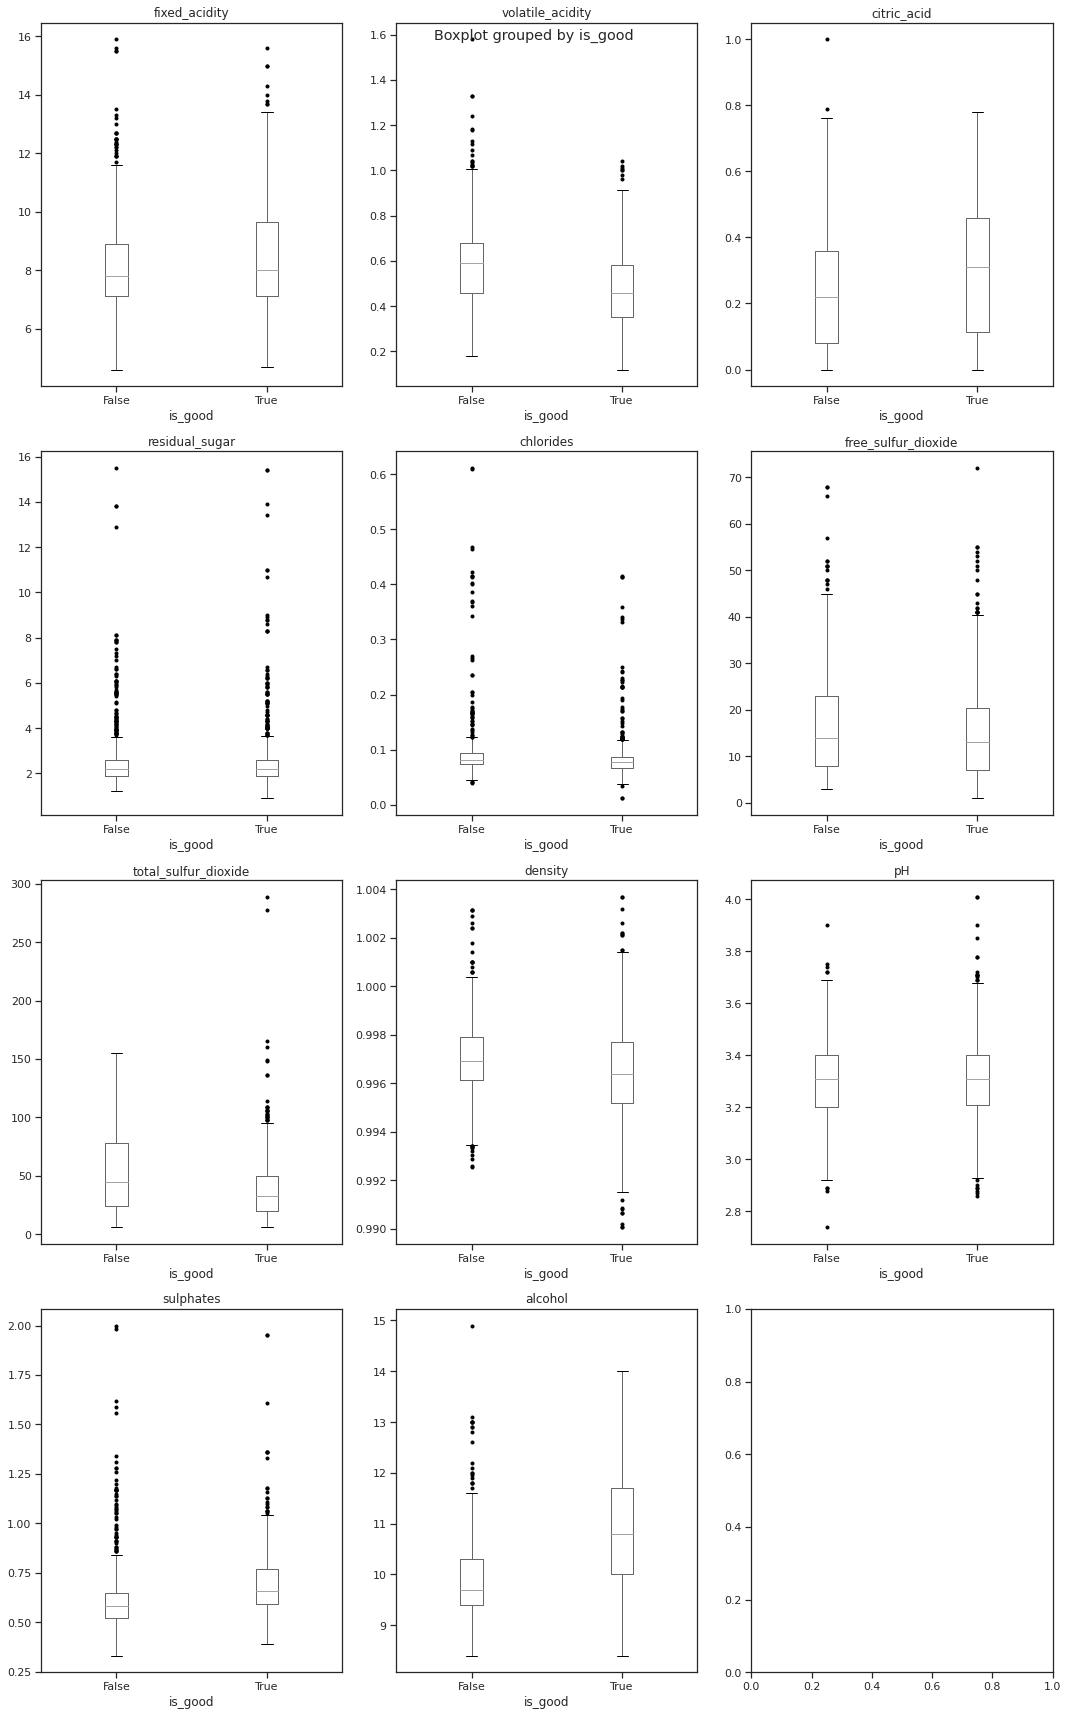

In [ ]:
rows = 4
cols = 3
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(5*cols, 6*rows))
axs = axs.flatten()
for i in range(len(predictor_columns)):
        wine_df.boxplot(predictor_columns[i], by="is_good", grid=False, ax=axs[i], sym='k.')
plt.tight_layout()

There's no single feature that can separate the data perfectly. Alcohol and total sulfur dioxide look important though.

## Tree-structured models
Let's now re-explore the modeling technique we introduced last class -- tree-structured models.  And in particular, classification trees, since our target is to predict whether the wine is good or not (binary classification).

For illustration, we will increase the complexity of the tree using the maximum depth allowed.

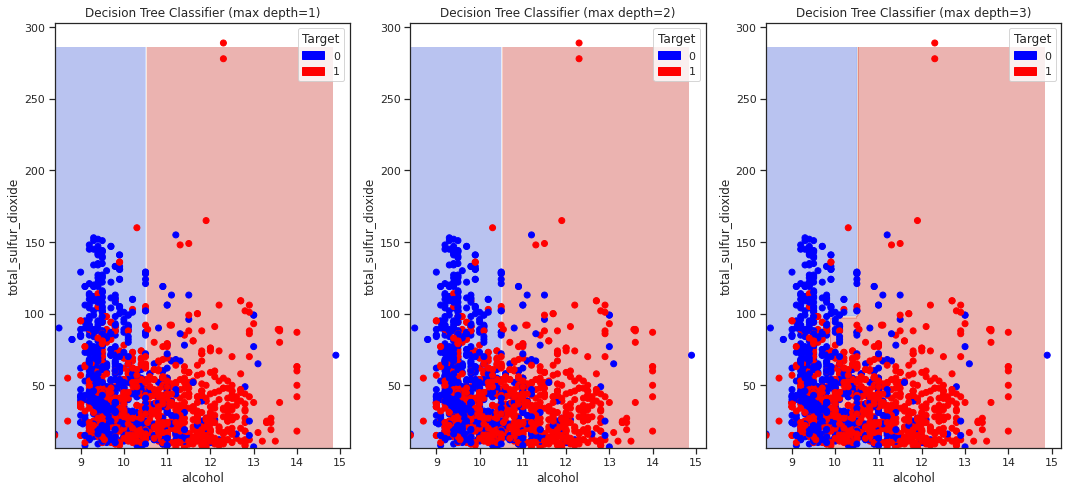

In [ ]:
from sklearn.tree import DecisionTreeClassifier
X = wine_df[predictor_columns]
Y = wine_df.is_good

def plot_trees(X, Y, col1, col2, depths, show_probs=False):
    ncol = 3
    nrows = np.ceil(len(depths) / ncol)
    plt.figure(figsize=[15, 7*nrows])

    for i in range(len(depths)):
        depth = depths[i]
        # Plot
        plt.subplot(nrows, ncol, 1+i)
        model = DecisionTreeClassifier(max_depth=depth, criterion="entropy")
        #Decision_Surface(X, col1, col2, Y, model, sample=0.1, gridsize=100,probabilities=show_probs)
        Decision_Surface(X, col1, col2, Y, model,probabilities=show_probs)
        plt.title("Decision Tree Classifier (max depth=" + str(depth) + ")")

    plt.tight_layout()
    plt.show()

plot_trees(X, Y, "alcohol", "total_sulfur_dioxide", depths=[1,2,3], show_probs=False)

### Trees are non-linear models

If you experiment with the tree depth, you will see that you can fit the data better and better. Deeper trees chop the instance space into smaller and smaller pieces.  Check it out below with the `depths` variable. (Will this finer and finer segmentation go on forever?)

**Extra:** Can you visualize the actual tree-structured model?  Hint: there's a function to do it in last week's notebook.  [Caveat: Visualizing huge trees isn't so effective.]

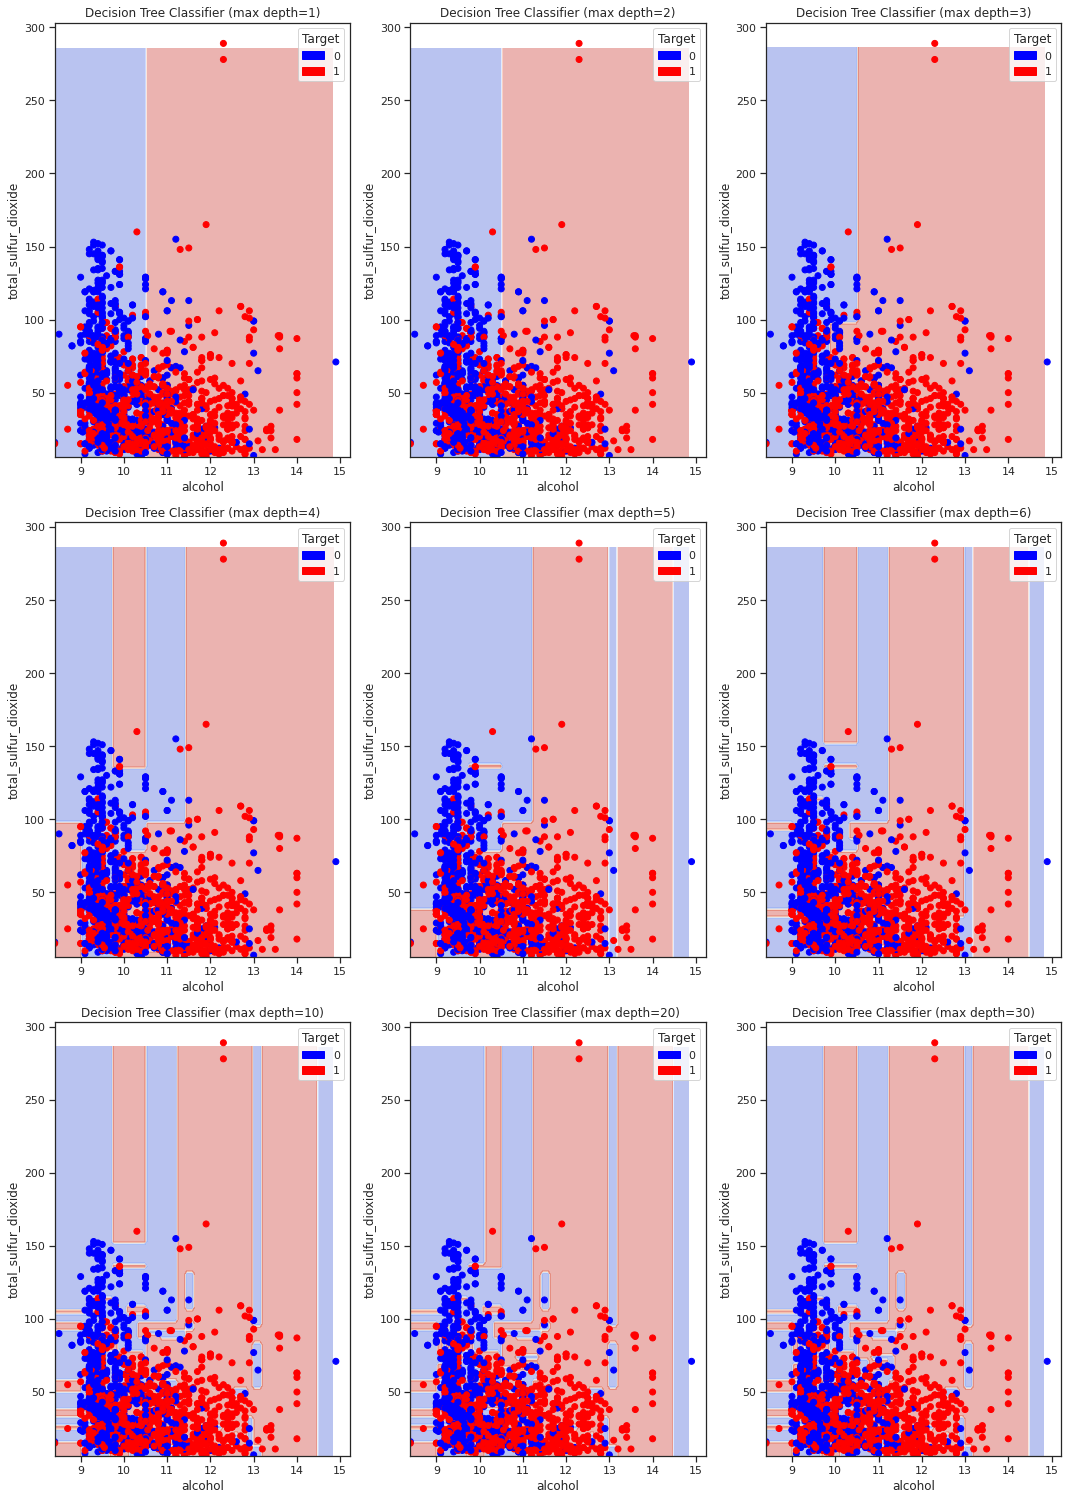

In [ ]:
plot_trees(X, Y, "alcohol", "total_sulfur_dioxide", depths=[1,2,3,4,5,6,10,20,30])

## Linear discriminant models

Chapter 4 introduces linear models.  Let's try building one on this data set.

Looking at the data (see scatterplots above), can you estimate by eye where a good linear discriminant would be?

If you remember, linear regression looks like this:

$$ y = b + a_1 x_1 + a_2 x_2 + a_3 x_3 + ... $$

If you are estimating the probability between two different classes, traditional linear regression may not work as well as you hope. Probabilities need to be bounded between zero and one. To solve this problem, a common tool is to use a **logistic regression**.  Chapter 4 describes it. You can also find logistic regression modeling in the sklearn package.

Let's plot both of them together to see what they look like.

In [ ]:
from sklearn.linear_model import LogisticRegression

def plot_linear(X, Y, col, model_type, ymin=-0.1, ymax=1.1, sample=1):
    if model_type == "Linear Regression":
        model = LinearRegression()
        predict_fn = model.predict
    else:
        model = LogisticRegression()
        predict_fn = lambda obs: model.predict_proba(obs)[:, 1]
    title = model_type + " Regression"
    # Fit model
    col_min = X[col].min()
    col_max = X[col].max()
    col_df = pd.DataFrame(X[col], columns=[col])
    model.fit(col_df, Y)
    # Evaluate predictions
    Y_pred = predict_fn(col_df)
    mse = mean_squared_error(Y, Y_pred)
    # Plot prediciton line
    col_line = pd.DataFrame(np.linspace(col_min, col_max, 100), columns=[col])
    plt.plot(col_line, predict_fn(col_line))
    # Plot sample
    indices = np.random.permutation(range(len(Y)))[:int(sample*len(Y))].tolist()
    plt.scatter(col_df[col][indices], Y[indices], edgecolor='b')
    plt.xlabel(col)
    plt.ylabel("Good?")
    plt.xlim((col_min, col_max))
    plt.ylim((ymin, ymax))
    plt.title("%s, MSE %0.3f" % (title, mse))

def linear_predict(model, X):
    return model.predict(X)

def logistic_predict(model, X):
    return model.predict_proba(X)[:, 1]

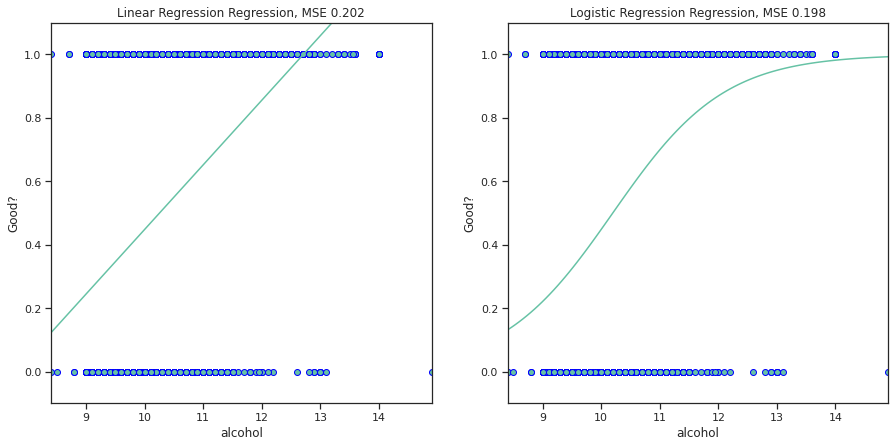

In [ ]:
plt.figure(figsize=[15,7])

plt.subplot(1, 2, 1)
plot_linear(X, Y, "alcohol", "Linear Regression")

plt.subplot(1,2,2)
plot_linear(X, Y, "alcohol", "Logistic Regression")

And, of course, we can look at the decision surface produced by linear and logistic regression

In [ ]:
from sklearn.metrics import accuracy_score

def training_accy(X, y, model):
    y_hat = model.fit(X, y).predict(X)
    return accuracy_score(y, [1 if ty > 0.5 else 0 for ty in y_hat])

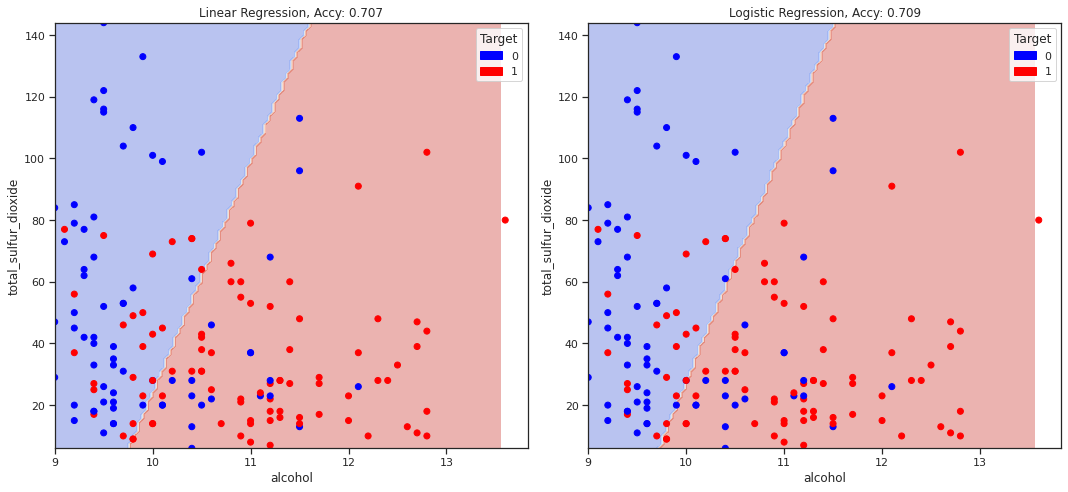

In [ ]:
plt.figure(figsize=[15,7])

plt.subplot(1, 2, 1)
Decision_Surface(X, "alcohol", "total_sulfur_dioxide", Y, LinearRegression(), sample=0.1, probabilities=False)
lin_accy = training_accy(X[["alcohol", "total_sulfur_dioxide"]], Y, LinearRegression())
plt.title("Linear Regression, Accy: %0.3f" % lin_accy)

plt.subplot(1, 2, 2)
Decision_Surface(X, "alcohol", "total_sulfur_dioxide", Y, LogisticRegression(), sample=0.1, probabilities=False)
lr_accy = training_accy(X[["alcohol", "total_sulfur_dioxide"]], Y, LogisticRegression())
plt.title("Logistic Regression, Accy: %0.3f" % lr_accy)

plt.tight_layout()
plt.show()

### Estimating Probabilities


For many business problems, we don't need just to estimate the categorical target variable, but we want to estimate the probability that a particular value will be taken. Just about every classification model can also tell you the estimated probability of class membership.

Intuitively, how would you generate probabilities from a classification tree? From a linear discriminant?

Let's look at the probabilities estimated by these models. As shown below, you can visualize the probabilities both for the linear model and the tree-structured model. Note that the native `LinearRegression` class in sklearn doesn't have probability estimation capability (Why do you think?). We can only perform this operation with logistic regression.

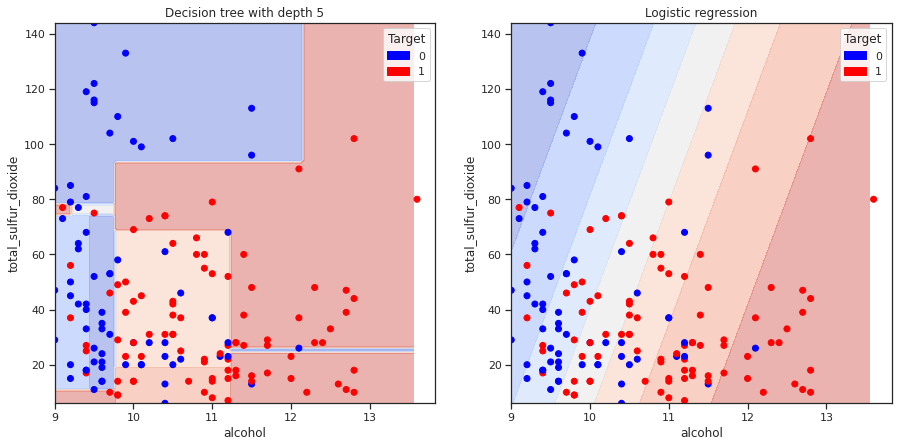

In [ ]:
plt.figure(figsize=[15,7])

plt.subplot(1, 2, 1)
depth=5
model = DecisionTreeClassifier(max_depth=depth, criterion="entropy")
Decision_Surface(X, "alcohol", "total_sulfur_dioxide", Y, model, sample=0.1, probabilities=True)
plt.title("Decision tree with depth " + str(depth))

plt.subplot(1, 2, 2)
model = LogisticRegression()
Decision_Surface(X, "alcohol", "total_sulfur_dioxide", Y, model, sample=0.1, probabilities=True)
plt.title("Logistic regression")
plt.show()

Let's revisit the deeper and deeper trees from above, but this time visualizing the probabilities.  

(Do the probabilities for the last trees look odd? )


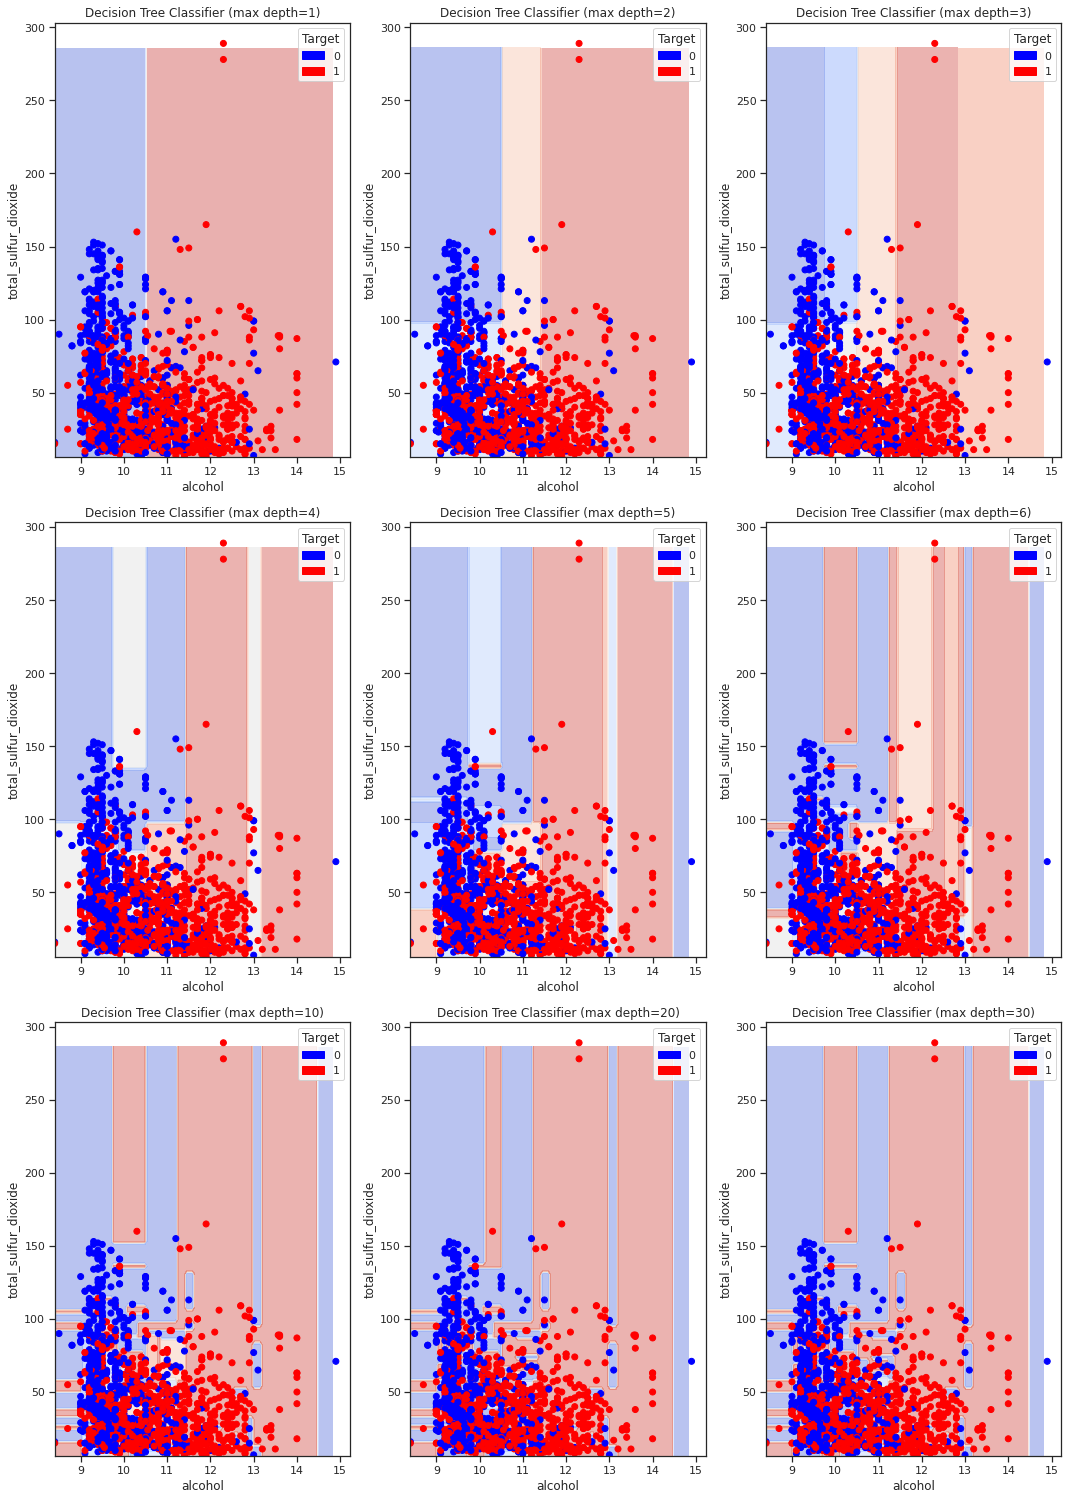

In [ ]:
plot_trees(X, Y, "alcohol", "total_sulfur_dioxide", depths=[1,2,3,4,5,6,10,20,30], show_probs=True)

### Non-linear numeric models

Tree-structured models are non-linear, and can fit the data very well. It seems like a linear model possibly cannot. Can we use the mechanism of fitting linear models to generate non-linear boundaries with logistic regression?

Yes! We can do this by adding non-linear features, such as  $ x^2 $  or  $ x^3 $ for any feature $ x $. We can even include a full set of polynomial feature interactions: given input features $x_1$ and $x_2$, we can, for instance,  build models and prediction on $x_1 + x_2 + x_1^2 + x_2^2 + x_1x_2$.

This is one of the most common ways of introducing non-linearity into numeric function modeling: use a linear function learner, but introduce non-linear features.

In [ ]:
def polynomial_model(model=LogisticRegression(), degree=1):
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    pipeline = Pipeline([("polynomial_features", polynomial_features), ("model", model)])
    return pipeline

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


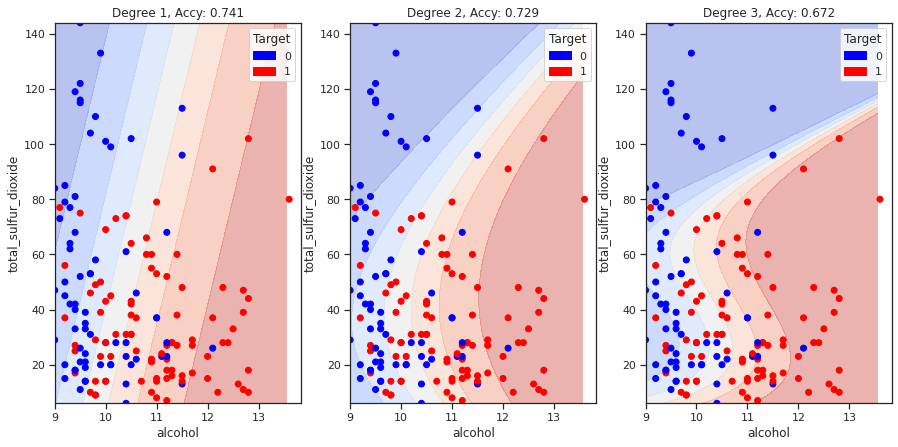

In [ ]:
plt.figure(figsize=[15,7])

degrees = [1,2,3]
for i in range(len(degrees)):
    model = polynomial_model(LogisticRegression(), degrees[i])
    plt.subplot(1, len(degrees), i+1)
    Decision_Surface(X, "alcohol", "total_sulfur_dioxide", Y, model, probabilities=True, sample=0.1)
    accy = training_accy(X, Y, model)
    plt.title("Degree %d, Accy: %0.3f" % (degrees[i], accy))
plt.show()

Which model is better in this case?? Look at the **accuracy** of each one. Accuracy is simply the count of correct decisions divided by the total number of decisions. Here we are computing the accuracy of the model when it makes predictions on the training set, examples the model "already knows the answer to".

[From sklearn documentation on sklearn.metrics.accuracy_score: "In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true."  [More about the accuracy measure..](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)]